In [1]:
# Let's have numpy and visualizations
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import peewee as pw
import time

def show_raw(nd_array):
    """Simply show the data"""
    from matplotlib.pyplot import imshow, show
    imshow(nd_array)  # interpolation="nearest")
    show()

/home/l/prog/py3.6sys/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


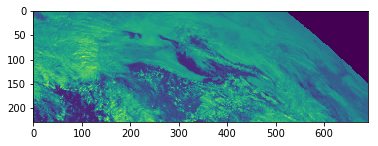

In [2]:
# Let's have 4D data to save / load - in .npy format
data = np.load("slovakia.npy")
# data.shape == (10, 25, 229, 691)
# dimensions: day [0-9], slot [0-24],
#  latitude linspace(49.66, 47.70, 229),
#  longitude linspace(16.81, 22.61, 691)
show_raw(data[1, 12, :, :])  # first day's noon's slot

In [3]:
# Let's have various .nc files
def make_chunked_dataset(ds, chunksizes=None):
    """In .nc file - create dimensions + variable with given chunksizes"""
    ds.createDimension("day", 10)
    ds.createDimension("slot", 25)
    ds.createDimension("latitude", 229)
    ds.createDimension("longitude", 691)
    ds.createVariable(varname="slovakia",
                      datatype=np.int16,
                      dimensions=("day", "slot", "latitude", "longitude"),
                      zlib=True,
                      chunksizes=chunksizes,
                      fill_value=np.iinfo(np.int16).min)

In [4]:
with nc.Dataset("slovakia_chunked_1_big.nc", "w") as ds:
    make_chunked_dataset(ds, chunksizes=(10,25,229,691))
    ds["slovakia"][...] = data

with nc.Dataset("slovakia_chunked_4_time.nc", "w") as ds:
    make_chunked_dataset(ds, chunksizes=(10,25,2,2))
    ds["slovakia"][...] = data
    
with nc.Dataset("slovakia_chunked_4_space.nc", "w") as ds:
    make_chunked_dataset(ds, chunksizes=(2,2,25,50))
    ds["slovakia"][...] = data
    
with nc.Dataset("slovakia_chunked_optimally.nc", "w") as ds:
    make_chunked_dataset(ds, chunksizes=(2,4,8,12))
    ds["slovakia"][...] = data

with nc.Dataset("slovakia_chunked_minimally.nc", "w") as ds:
    make_chunked_dataset(ds, chunksizes=(1,1,1,1))
    # we must do it per partes - else RAM sadly exceeds! :-(((
    for i in range(10):
        for j in range(25):
            ds["slovakia"][i][j] = data[i][j]

In [5]:
# Let's check runtime of the reading Tatry subslice on last day's noon
print("slovakia - numpy internal format")
%timeit np.load("slovakia.npy")
print("slovakia_chunked_1_big.nc")
%timeit nc.Dataset("slovakia_chunked_1_big.nc")["slovakia"][-1, 12, 161:190, 329:435]
print("slovakia_chunked_4_time.nc")
%timeit nc.Dataset("slovakia_chunked_4_time.nc")["slovakia"][-1, 12, 161:190, 329:435]
print("slovakia_chunked_4_space.nc")
%timeit nc.Dataset("slovakia_chunked_4_space.nc")["slovakia"][-1, 12, 161:190, 329:435]
print("slovakia_chunked_optimally.nc")
%timeit nc.Dataset("slovakia_chunked_optimally.nc")["slovakia"][-1, 12, 161:190, 329:435]
print("slovakia_chunked_minimally.nc")
%timeit nc.Dataset("slovakia_chunked_minimally.nc")["slovakia"][-1, 12, 161:190, 329:435]


slovakia - numpy internal format
18.6 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
slovakia_chunked_1_big.nc
375 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
slovakia_chunked_4_time.nc
19.3 ms ± 758 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
slovakia_chunked_4_space.nc
977 µs ± 59.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
slovakia_chunked_optimally.nc
1.24 ms ± 72.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
slovakia_chunked_minimally.nc
1.06 ms ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
